# MD Analysis Tomás Frazão

**Last update: 17th October 2022**


some qualitative studies on the MD convergence/sampling quality are performed in this notebook. 
Also a distance is monitored along the simulation.

Concretely:
NOTE: you do not need to load an aligned trajectory as this will be done here.
IMPORTANT: Update SELECTIONS of atoms for fittings according to your system


### How to use this notebook


1. You have to run the cell containing the dependencies imports before starting to run the code. An easy way to have all_loop these dependencies install_looped is to create a conda environment with:

`conda create -n md_analysis -c anaconda -c conda-forge -c ambermd jupyter pytraj mdtraj matplotlib scikit-learn`


### Dependencies of this notebook
* matplotlib (-c conda-forge)
* pytraj (-c ambermd)
* scikit-learn (-c anaconda)
* mdtraj

In [1]:
%matplotlib inline
import pandas as pd
import csv
import pytraj as pt
import numpy as np
import math
import matplotlib.pyplot as plt
# we will also use mdtraj
import mdtraj as md
from mdtraj.testing import get_fn
#
from sklearn.decomposition import PCA
import time

import matplotlib.font_manager 
from matplotlib import rc

In [2]:
from matplotlib import font_manager

font_dirs = ['/home/tomas/Downloads']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Arial'

In [3]:
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

## Concept of convergence
"From our point of view and for our scope, a MD trajectory is considered converged when a full exploration of the conformational space is achieved. In particular, a stable conformation or a pull of relative stable conformations visited for a statistically consistent number of times is considered a convergence indicator."

"From this statistical point of view **is not possible to describe if a simulation is absolutely converged** [1]. However, there are several methods in the literature that trough **qualitative and visual analyses** can quickly suggest that the simulation has not run enough and can help **to achieve a good sampling quality**."

## 0. Selection of atoms object of study
Before starting the convergence analyses, the first thing is to define which part of the system will be object of study. 

Typically, very flexible parts such as terminal residues are avoided, and representative atoms of the backbone like alpha carbons are selected.

#### 0.1 Load the trajectory and topology files
Different possibilities are given (some commented) depending on the format of the trajectory files.
Possibilities if the MDs are loaded with pytraj:(basically amber formats)

http://amber-md.github.io/pytraj/latest/read_and_write.html

If the MDs are loaded with mdtraj, we have more possibilities, including xtc (gromacs) +pdb for topology, or a pdb traj.
http://mdtraj.org/1.6.2/load_functions.html#the-trajectory-object

We indicate also the length of the trajectory in ns only for correct axis labels in plots.

In [4]:
TRAJECTORY_I = './I_AsP2Ox_Apo.xtc'  # To be used with md.load below
TOPOLOGY_I = 'I_AsP2Ox_Apo.pdb'
TRAJECTORY_II = './II_AsP2Ox_Glc_Semi.xtc'  
TOPOLOGY_II = 'II_AsP2Ox_Glc_Semi.pdb'
TRAJECTORY_III = './III_AsP2Ox_Glc_Open.xtc'  
TOPOLOGY_III = 'III_AsP2Ox_Glc_Open.pdb'
TRAJECTORY_IV = './IV_AsP2Ox_Man_Crystal.xtc'
TOPOLOGY_IV = 'IV_AsP2Ox_Man_Crystal.pdb'

TRAJECTORY_LENGTH = 400 #Length of the trajectory in ns (for correct axis labels in plots)

In [5]:
# pytraj/cpptraj does not know how to read xtc trajectories so we use mdtraj instead.
mdtraj_I = md.load(TRAJECTORY_I, top=TOPOLOGY_I) 
mdtraj_II = md.load(TRAJECTORY_II, top=TOPOLOGY_II) 
mdtraj_III = md.load(TRAJECTORY_III, top=TOPOLOGY_III) 
mdtraj_IV = md.load(TRAJECTORY_IV, top=TOPOLOGY_IV) 

mdtraj_I
#mdtraj_II
#mdtraj_III
#mdtraj_IV

<mdtraj.Trajectory with 956 frames, 7577 atoms, 508 residues, and unitcells at 0x7fcf9a582b10>

In [6]:
# convert mdtraj.Trajectory to pytraj.Trajectory
# need to provide topology_name (a pdb file)
# and convert traj's dtype of float32 to float64 (f8 in python)

traj_I = pt.Trajectory(xyz=mdtraj_I.xyz.astype('f8'), top=TOPOLOGY_I)
traj_II = pt.Trajectory(xyz=mdtraj_II.xyz.astype('f8'), top=TOPOLOGY_II)
traj_III = pt.Trajectory(xyz=mdtraj_III.xyz.astype('f8'), top=TOPOLOGY_III)
traj_IV = pt.Trajectory(xyz=mdtraj_IV.xyz.astype('f8'), top=TOPOLOGY_IV)
print(traj_I)
print(traj_II)
print(traj_III)
print(traj_IV)

pytraj.Trajectory, 956 frames: 
Size: 0.161907 (GB)
<Topology: 7577 atoms, 508 residues, 2 mols, non-PBC>
           
pytraj.Trajectory, 1001 frames: 
Size: 0.170065 (GB)
<Topology: 7601 atoms, 509 residues, 3 mols, non-PBC>
           
pytraj.Trajectory, 1001 frames: 
Size: 0.169439 (GB)
<Topology: 7573 atoms, 507 residues, 3 mols, non-PBC>
           
pytraj.Trajectory, 1001 frames: 
Size: 0.169954 (GB)
<Topology: 7596 atoms, 507 residues, 3 mols, non-PBC>
           


In [7]:
# compare mdtraj's m_traj and pytraj' s traj
(mdtraj_I.xyz - traj_I.xyz)[:2]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

#### 0.2 Select the atoms that will be object of the study and align core
We use the notation of pytraj to select the atoms:

https://amber-md.github.io/pytraj/latest/atom_mask_selection.html


In [8]:
# This can be used for initial fitting. Corresponds to core except flexible loop and terminal of MCoA
#ref_SELECTION = '!(:1-6)&!(:285-313)&(@CA)'
ref_SELECTION = '(:5-509)&(@CA)'

# This corresponds to all Ca (including loop) except flexible terminal. Used for RMSD.
SELECTION = '(:5-509)&(@CA)'


Now the initial tajectory will be aligned. So no need to load aligned trajectory. 

In [9]:
trajectory_I = pt.align(traj_I, ref=0, ref_mask='ref_SELECTION', mass=False, top=None, frame_indices=None)
trajectory_II = pt.align(traj_II, ref=0, ref_mask='ref_SELECTION', mass=False, top=None, frame_indices=None)
trajectory_III = pt.align(traj_III, ref=0, ref_mask='ref_SELECTION', mass=False, top=None, frame_indices=None)
trajectory_IV = pt.align(traj_IV, ref=0, ref_mask='ref_SELECTION', mass=False, top=None, frame_indices=None)

trajectory_I[SELECTION]

pytraj.Trajectory, 956 frames: 
Size: 0.010748 (GB)
<Topology: 503 atoms, 503 residues, 503 mols, non-PBC>
           

## 1. RMSD from the first frame
- If the plot does not reach a steady state (meaning on that may fluctuate significantly, but has no significant trend), the system is clearly not converged. [1]
- It is of limited utility, because it contains little information about what states are being sampled. [1]
- It should be considered as an equilibration test, starting the "production part" of the MD when the RMSD achieves a plateau after the curve has increased rapidly at the begining. This "equilibration" part should be discarded in further production analyses. [2]

Calculate RMSD of all frames with respect to the first frame

In [24]:
rmsd_I = pt.analysis.rmsd.rmsd(traj=trajectory_I, mask=SELECTION, ref=0, update_coordinate=False, nofit=True)  #NoFit because I aligned before only core
rmsd_II = pt.analysis.rmsd.rmsd(traj=trajectory_II, mask=SELECTION, ref=0, update_coordinate=False, nofit=True)
rmsd_III = pt.analysis.rmsd.rmsd(traj=trajectory_III, mask=SELECTION, ref=0, update_coordinate=False, nofit=True)
rmsd_IV = pt.analysis.rmsd.rmsd(traj=trajectory_IV, mask=SELECTION, ref=0, update_coordinate=False, nofit=True)


rmsd_I_pd = pd.DataFrame(10*rmsd_I)
rmsd_II_pd = pd.DataFrame(10*rmsd_II)
rmsd_III_pd = pd.DataFrame(10*rmsd_III)
rmsd_IV_pd = pd.DataFrame(10*rmsd_IV)
lenght_pd = pd.DataFrame(TRAJECTORY_LENGTH*a/len(rmsd_II) for a in range(len(10*rmsd_II)))

rmsd_I_pd.to_csv('./csvfiles/cMD_rmsd_I.csv')
rmsd_II_pd.to_csv('./csvfiles/cMD_rmsd_II.csv')
rmsd_III_pd.to_csv('./csvfiles/cMD_rmsd_III.csv')
rmsd_IV_pd.to_csv('./csvfiles/cMD_rmsd_IV.csv')
lenght_pd.to_csv('./csvfiles/cMD_rmsd_len.csv')

print(len(rmsd_I))
print(len(rmsd_II))
print(len(rmsd_III))
print(len(rmsd_IV))

print(rmsd_I[200])

956
1001
1001
1001
0.21502227892470557


Plot the data

In [11]:
RMSD_PLOT_FILENAME = './AsP2Ox_MD_RMSD.png' #Output filename for the plot

RMSD_COLOR = 'forestgreen' #Color of the line
MAX_Y = math.ceil(10*rmsd_I.max()) #It can be modified if you want to change the scale of the plot

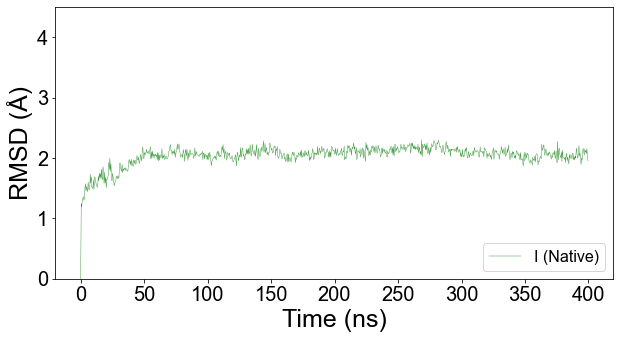

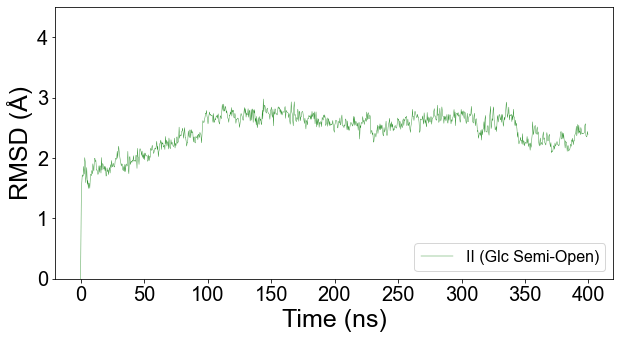

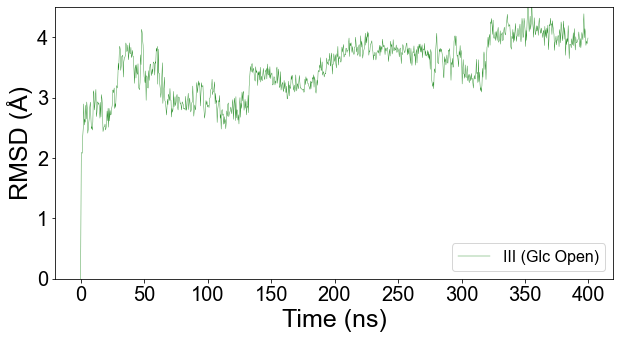

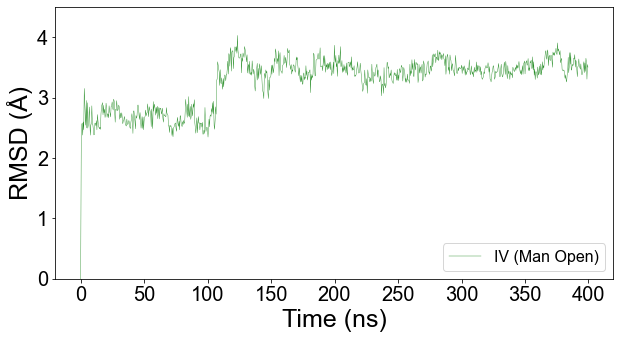

In [12]:
plt.rcParams['font.size']=20

plt.figure(figsize=(10,5))
plt.plot([TRAJECTORY_LENGTH*a/len(rmsd_I) for a in range(len(10*rmsd_I))], 10*rmsd_I, linewidth=0.4, color=RMSD_COLOR)
plt.ylim(0, 4.5)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel(u'RMSD (Å)',fontsize=25)
plt.legend(['I (Native)'], fontsize=16, bbox_to_anchor =(1, 0.16), ncol = 2)
plt.savefig('RMSD_I.png', bbox_inches='tight')


plt.figure(figsize=(10,5))
plt.plot([TRAJECTORY_LENGTH*a/len(rmsd_II) for a in range(len(10*rmsd_II))], 10*rmsd_II, linewidth=0.4, color=RMSD_COLOR)
plt.ylim(0, 4.5)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel(u'RMSD (Å)',fontsize=25)
plt.legend(['II (Glc Semi-Open)'], fontsize=16, bbox_to_anchor =(1, 0.16), ncol = 2)
plt.savefig('RMSD_II.png', bbox_inches='tight')

plt.figure(figsize=(10,5))
plt.plot([TRAJECTORY_LENGTH*a/len(rmsd_III) for a in range(len(10*rmsd_III))], 10*rmsd_III, linewidth=0.4, color=RMSD_COLOR)
plt.ylim(0, 4.5)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel(u'RMSD (Å)',fontsize=25)
plt.legend(['III (Glc Open)'], fontsize=16, bbox_to_anchor =(1, 0.16), ncol = 2)
plt.savefig('RMSD_III.png', bbox_inches='tight')

plt.figure(figsize=(10,5))
plt.plot([TRAJECTORY_LENGTH*a/len(rmsd_IV) for a in range(len(10*rmsd_IV))], 10*rmsd_IV, linewidth=0.4, color=RMSD_COLOR)
plt.ylim(0, 4.5)
plt.xlabel('Time (ns)', fontsize=25)
plt.ylabel(u'RMSD (Å)',fontsize=25)
plt.legend(['IV (Man Open)'], fontsize=16, bbox_to_anchor =(1, 0.16), ncol = 2)
plt.savefig('RMSD_IV.png', bbox_inches='tight')

## 2a. Substrate-loop (Ala532-CA) to N5 distance

In [33]:
# compute distance between S347-C and N5
Sloop_I = pt.distance(trajectory_I, '@5087 :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Sloop_II = pt.distance(trajectory_II, '@5087 :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Sloop_III = pt.distance(trajectory_III, '@5087 :FAD@N5') #7523 (N5 on pdb) doesn´t give the right plot. This was check on vmd!!
Sloop_IV = pt.distance(trajectory_IV, '@5086 :FAD@N5') #7522 (N5 on pdb) doesn´t give the right plot. This was check on vmd!!

#The N5 problem might have something to to with the fact that the FAD chain in the pdb file
#is diferent in II and IV (A12001; F in I and II). Tried to change it but the xtc file might also have been afected 

Sloop_I_pd = pd.DataFrame(10*Sloop_I)
Sloop_II_pd = pd.DataFrame(10*Sloop_II)
Sloop_III_pd = pd.DataFrame(10*Sloop_III)
Sloop_IV_pd = pd.DataFrame(10*Sloop_IV)


Sloop_I_pd.to_csv('./csvfiles/cMD_Sloop_I.csv')
Sloop_II_pd.to_csv('./csvfiles/cMD_Sloop_II.csv')
Sloop_III_pd.to_csv('./csvfiles/cMD_Sloop_III.csv')
Sloop_IV_pd.to_csv('./csvfiles/cMD_Sloop_IV.csv')

print(Sloop_I)
print(Sloop_II)
print(Sloop_III)
print(Sloop_IV)

[1.67980304 1.72331443 1.73048967 ... 1.84159829 1.86980689 1.82348053]
[1.90664763 2.00800108 2.17650068 ... 2.10072288 1.96858011 2.13238402]
[2.77549748 2.5714908  2.64670829 ... 3.29242027 3.18642233 3.39086594]
[2.72889649 2.57549193 2.75073178 ... 3.14432776 3.067315   3.14158875]


In [12]:
DISTANCE_LOOP_PLOT_FILENAME = './AsP2Ox_DistSubLoop.png' #Output filename for the plot
DISTANCE_LOOP_DATA_FILE = "./AsP2Ox_DistSubLoop.txt" #Text file to store data

#DISTANCE_LOOP_COLOR = 'red' #Color of the line
MAX_DISTANCE_LOOP = math.ceil(10*Sloop_I.max()) #It can be modified if you want to change the scale of the plot. If xtc.
MIN_DISTANCE_LOOP = math.ceil(10*Sloop_I.min()) #For use in PCA plot. If xtc, as before.

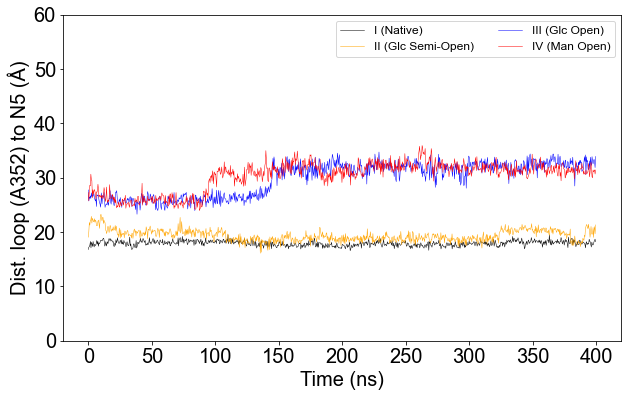

In [13]:
plt.rcParams['font.size']=20

#Plot the figure
plt.figure(figsize=(10,6))
plt.plot([TRAJECTORY_LENGTH*a/len(Sloop_I) for a in range(len(Sloop_I))], 
         10*Sloop_I, linewidth=0.5, color='black') #If xtc as units are nm (remove *10 if not)


plt.plot([TRAJECTORY_LENGTH*a/len(Sloop_II) for a in range(len(Sloop_II))], 
         10*Sloop_II, linewidth=0.5, color='orange') #If xtc as units are nm (remove *10 if not)


plt.plot([TRAJECTORY_LENGTH*a/len(Sloop_III) for a in range(len(Sloop_III))], 
         10*Sloop_III, linewidth=0.5, color='blue') #If xtc as units are nm (remove *10 if not)


plt.plot([TRAJECTORY_LENGTH*a/len(Sloop_IV) for a in range(len(Sloop_IV))], 
         10*Sloop_IV, linewidth=0.5, color='red') #If xtc as units are nm (remove *10 if not)
plt.ylim(0, 60)
plt.xlabel('Time (ns)')
plt.ylabel(u'Dist. loop (A352) to N5 (Å)')
plt.legend(['I (Native)', 'II (Glc Semi-Open)', 'III (Glc Open)', 'IV (Man Open)'], fontsize=12, bbox_to_anchor =(1, 1), ncol = 2)
plt.savefig(DISTANCE_LOOP_PLOT_FILENAME, bbox_inches='tight')
plt.show()

#And write the data into a text file
with open(DISTANCE_LOOP_DATA_FILE, "w") as f:
    for a, r in enumerate(Sloop_I):
        f.write("%f\t%f\n" %(TRAJECTORY_LENGTH*a/len(Sloop_I), r*10))  #If xtc read has units of nm (remove *10 if not)

## Tried to smooth the line:
### (ignore, at least for now)

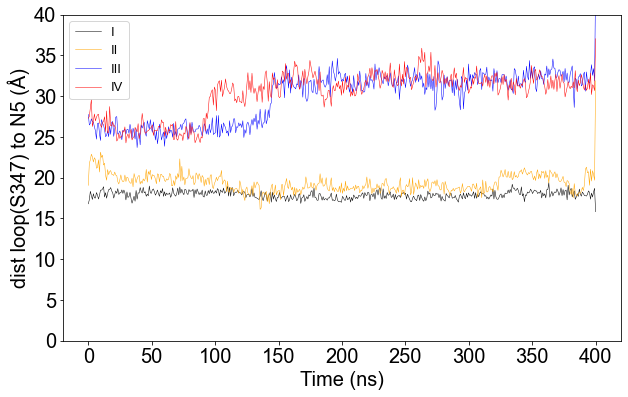

In [16]:
from scipy.interpolate import make_interp_spline

plt.rcParams['font.size']=20

#Plot the figure
plt.figure(figsize=(10,6))
xI=[TRAJECTORY_LENGTH*a/len(Sloop_I) for a in range(len(Sloop_I))]
yI=10*Sloop_I
X_Y_Spline = make_interp_spline(xI, yI)
x_I = np.linspace(0, 400, 500)
y_I = X_Y_Spline(x_I)
plt.plot(x_I, y_I, linewidth=0.5, color='black') #If xtc as units are nm (remove *10 if not)


xII=[TRAJECTORY_LENGTH*a/len(Sloop_II) for a in range(len(Sloop_II))]
yII=10*Sloop_II
X_Y_Spline = make_interp_spline(xII, yII)
x_II = np.linspace(0, 400, 500)
y_II = X_Y_Spline(x_II)
plt.plot(x_II, y_II, linewidth=0.5, color='orange') #If xtc as units are nm (remove *10 if not)


xIII=[TRAJECTORY_LENGTH*a/len(Sloop_III) for a in range(len(Sloop_III))]
yIII=10*Sloop_III
X_Y_Spline = make_interp_spline(xIII, yIII)
x_III = np.linspace(0, 400, 500)
y_III = X_Y_Spline(x_III)
plt.plot(x_III, y_III, linewidth=0.5, color='blue') #If xtc as units are nm (remove *10 if not)


xIV=[TRAJECTORY_LENGTH*a/len(Sloop_IV) for a in range(len(Sloop_IV))]
yIV=10*Sloop_IV
X_Y_Spline = make_interp_spline(xIV, yIV)
x_IV = np.linspace(0, 400, 500)
y_IV = X_Y_Spline(x_IV)
plt.plot(x_IV, y_IV, linewidth=0.5, color='red') #If xtc as units are nm (remove *10 if not)

plt.ylim(0, 40)
plt.xlabel('Time (ns)')
plt.ylabel(u'dist loop(S347) to N5 (Å)')
#plt.savefig('Sloop_smoothish', bbox_inches='tight')

plt.legend(['I', 'II', 'III', 'IV'],fontsize=13)



## 2b. Insertion (G84-CA) to N5 distance

In [10]:
# compute distance between P83-CG and N5
Iloop_I = pt.distance(trajectory_I, '@1091 :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Iloop_II = pt.distance(trajectory_II, '@1091 :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Iloop_III = pt.distance(trajectory_III, '@1091 :FAD@N5') #7523 (N5 on pdb) doesn´t give the right plot. This was check on vmd!!
Iloop_IV = pt.distance(trajectory_IV, '@1090 :FAD@N5') #7522 (N5 on pdb) doesn´t give the right plot. This was check on vmd!!

#The N5 problem might have something to to with the fact that the FAD chain in the pdb file
#is diferent in II and IV (A12001; F in I and II). Tried to change it but the xtc file might also have been afected 

Iloop_I_pd = pd.DataFrame(10*Iloop_I)
Iloop_II_pd = pd.DataFrame(10*Iloop_II)
Iloop_III_pd = pd.DataFrame(10*Iloop_III)
Iloop_IV_pd = pd.DataFrame(10*Iloop_IV)


Iloop_I_pd.to_csv('./csvfiles/cMD_Iloop_I.csv')
Iloop_II_pd.to_csv('./csvfiles/cMD_Iloop_II.csv')
Iloop_III_pd.to_csv('./csvfiles/cMD_Iloop_III.csv')
Iloop_IV_pd.to_csv('./csvfiles/cMD_Iloop_IV.csv')

print(Iloop_I)
print(Iloop_II)
print(Iloop_III)
print(Iloop_IV)

[1.93965052 2.01379536 1.99826134 ... 1.98438558 2.01590474 2.02825965]
[1.88688992 1.81705327 1.77560808 ... 1.44481861 1.57793212 1.48160608]
[3.0575067  2.70036776 3.0232722  ... 2.59164635 2.69826084 2.56618256]
[2.87346543 3.09899744 3.01011414 ... 2.38312251 2.41051308 2.72336626]


In [15]:
DISTANCE_INSERTION_PLOT_FILENAME = './AsP2Ox_DistInsertion.png' #Output filename for the plot
DISTANCE_INSERTION_DATA_FILE = "./AsP2Ox_DistInsertion.txt" #Text file to store data

#DISTANCE_INSERTION_COLOR = 'red' #Color of the line
MAX_DISTANCE_INSERTION = math.ceil(10*Iloop_I.max()) #It can be modified if you want to change the scale of the plot. If xtc.
MIN_DISTANCE_INSERTION = math.ceil(10*Iloop_I.min()) #For use in PCA plot. If xtc, as before.


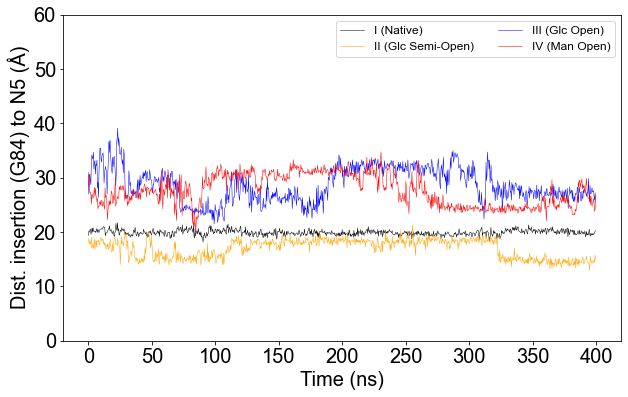

In [16]:
plt.rcParams['font.size']=20

#Plot the figure
plt.figure(figsize=(10,6))
plt.plot([TRAJECTORY_LENGTH*a/len(Iloop_I) for a in range(len(Iloop_I))], 
         10*Iloop_I, linewidth=0.5, color='black') #If xtc as units are nm (remove *10 if not)


plt.plot([TRAJECTORY_LENGTH*a/len(Iloop_II) for a in range(len(Iloop_II))], 
         10*Iloop_II, linewidth=0.5, color='orange') #If xtc as units are nm (remove *10 if not)


plt.plot([TRAJECTORY_LENGTH*a/len(Iloop_III) for a in range(len(Iloop_III))], 
         10*Iloop_III, linewidth=0.5, color='blue') #If xtc as units are nm (remove *10 if not)


plt.plot([TRAJECTORY_LENGTH*a/len(Iloop_IV) for a in range(len(Iloop_IV))], 
         10*Iloop_IV, linewidth=0.5, color='red') #If xtc as units are nm (remove *10 if not)
plt.ylim(0, 60)
plt.xlabel('Time (ns)')
plt.ylabel(u'Dist. insertion (G84) to N5 (Å)')
plt.legend(['I (Native)', 'II (Glc Semi-Open)', 'III (Glc Open)', 'IV (Man Open)'], fontsize=12, bbox_to_anchor =(1, 1), ncol = 2)
plt.savefig(DISTANCE_INSERTION_PLOT_FILENAME, bbox_inches='tight')
plt.show()


#And write the data into a text file
with open(DISTANCE_INSERTION_DATA_FILE, "w") as f:
    for a, r in enumerate(Iloop_I):
        f.write("%f\t%f\n" %(TRAJECTORY_LENGTH*a/len(Iloop_I), r*10))  #If xtc read has units of nm (remove *10 if not)

## 2a. Glc to N5 distance

In [12]:
# compute distance between P83-CG and N5

Glc_II = pt.distance(trajectory_II, '@7588 :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Glc_III = pt.distance(trajectory_III, '@7560 :FAD@N5') #7523 (N5 on pdb) doesn´t give the right plot. This was check on vmd!!


#The N5 problem might have something to to with the fact that the FAD chain in the pdb file
#is diferent in II and IV (A12001; F in I and II). Tried to change it but the xtc file might also have been afected 


print(Glc_II)
print(Glc_III)


[0.42038714 0.46028749 0.43612653 ... 0.41858247 0.40723593 0.44348151]
[0.40598817 0.41390879 0.42539468 ... 5.47232512 5.49334752 4.06795542]


In [13]:
DISTANCE_GLC_FAD_FILENAME = './AsP2Ox_DistGlc.png' #Output filename for the plot
DISTANCE_INSERTION_DATA_FILE = "./AsP2Ox_DistInsertion.txt" #Text file to store data

#DISTANCE_INSERTION_COLOR = 'red' #Color of the line
MAX_DISTANCE_INSERTION = math.ceil(10*Iloop_I.max()) #It can be modified if you want to change the scale of the plot. If xtc.
MIN_DISTANCE_INSERTION = math.ceil(10*Iloop_I.min()) #For use in PCA plot. If xtc, as before.


In [14]:
Glc_list = ['Glc_II','Glc_III']
Glc_table = pd.DataFrame([Glc_II, Glc_III],
                                    index = Glc_list)
Glc_table = Glc_table.transpose()

Glc_table.to_csv('./csvfiles//cMD_Glc_all.csv')
Glc_table

,Glc_II,Glc_III
0,0.420387,0.405988
1,0.460287,0.413909
2,0.436127,0.425395
3,0.403190,0.378746
4,0.439044,0.440576
...,...,...
996,0.401601,4.935556
997,0.411720,5.389746
998,0.418582,5.472325
999,0.407236,5.493348


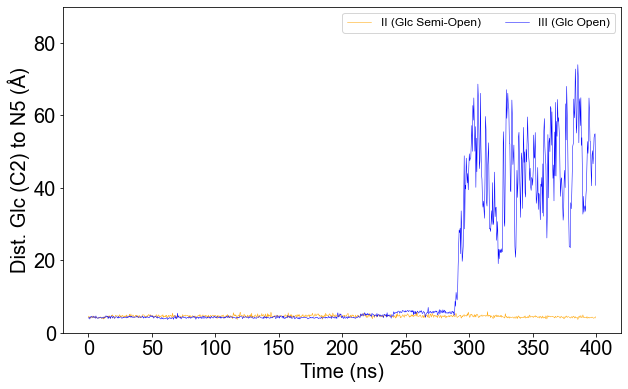

In [19]:
plt.rcParams['font.size']=20

#Plot the figure
plt.figure(figsize=(10,6))
plt.plot([TRAJECTORY_LENGTH*a/len(Glc_II) for a in range(len(Glc_II))], 
         10*Glc_II, linewidth=0.5, color='orange') #If xtc as units are nm (remove *10 if not)


plt.plot([TRAJECTORY_LENGTH*a/len(Glc_III) for a in range(len(Glc_III))], 
         10*Glc_III, linewidth=0.5, color='blue') #If xtc as units are nm (remove *10 if not)


plt.ylim(0, 90)
plt.xlabel('Time (ns)')
plt.ylabel(u'Dist. Glc (C2) to N5 (Å)')
plt.legend([ 'II (Glc Semi-Open)', 'III (Glc Open)'], fontsize=12, bbox_to_anchor =(1, 1), ncol = 2)
plt.savefig(DISTANCE_GLC_FAD_FILENAME, bbox_inches='tight')
plt.show()


#And write the data into a text file
with open(DISTANCE_INSERTION_DATA_FILE, "w") as f:
    for a, r in enumerate(Glc_II):
        f.write("%f\t%f\n" %(TRAJECTORY_LENGTH*a/len(Glc_II), r*10))  #If xtc read has units of nm (remove *10 if not)

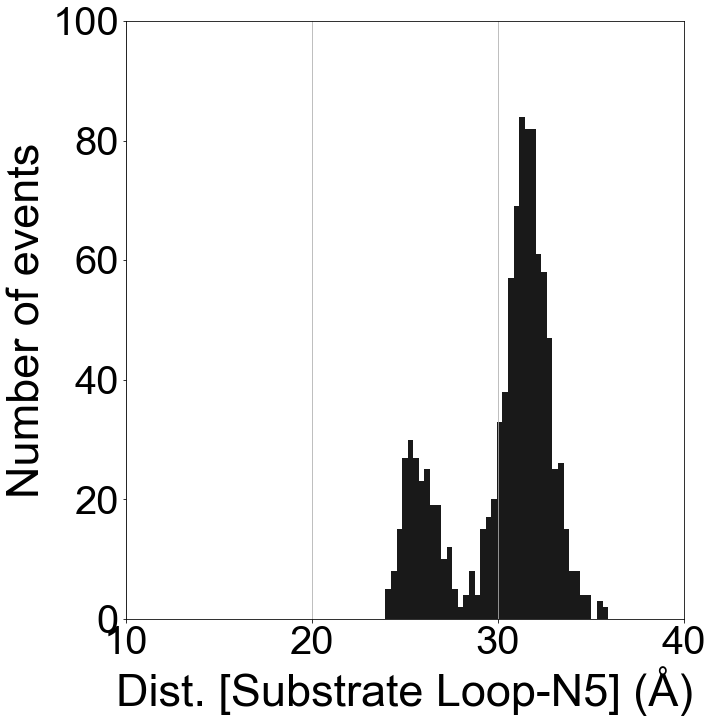

In [22]:
plt.rcParams['font.size']=45
plt.figure(figsize=(10,11))
plt.hist(Sloop_IV*10, bins=40, facecolor='black', alpha=0.9)
#plt.hist(Sloop_Irep, bins=40, facecolor='grey', alpha=0.8)
plt.xlabel("Dist. [Substrate Loop-N5] (Å)")
plt.ylabel("Number of events")
plt.ylim(0,100)
plt.grid(axis='x')
plt.xlim(10,40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.legend(['IV (Mang Open)'], fontsize=16, bbox_to_anchor =(1, 1), ncol = 1)
#plt.show()
plt.savefig("./hist_Sloop_IV.png", bbox_inches='tight', dpi=600)

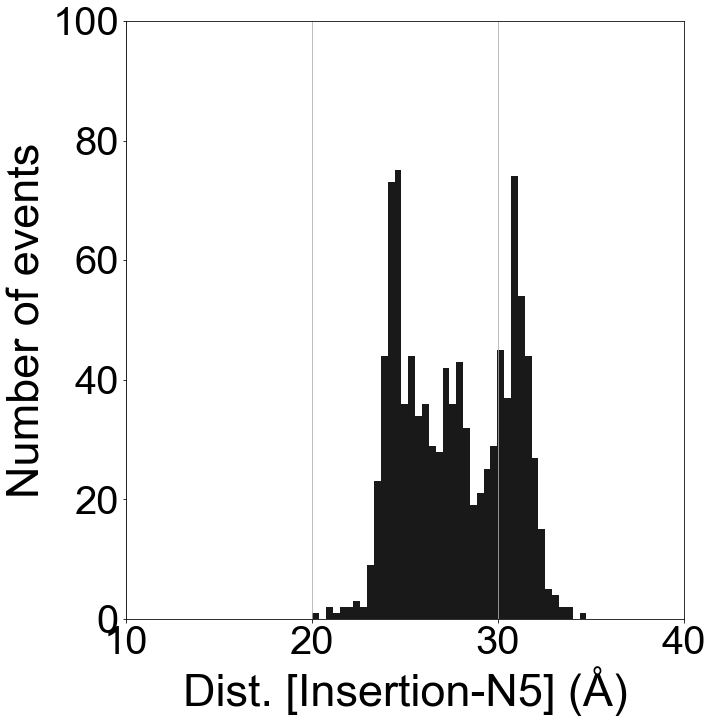

In [23]:
plt.figure(figsize=(10,11))
plt.hist(Iloop_IV*10, bins=40, facecolor='black', alpha=0.9)
#plt.hist(Sloop_Irep, bins=40, facecolor='grey', alpha=0.8)
plt.xlabel("Dist. [Insertion-N5] (Å)", fontsize=45)
plt.ylabel("Number of events", fontsize=45)
plt.ylim(0,100)
plt.grid(axis='x')
plt.xlim(10,40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.legend(['IV (Mang Open)'], fontsize=16, bbox_to_anchor =(1, 1), ncol = 1)
#plt.show()
plt.savefig("./hist_Iloop_IV.png", bbox_inches='tight', dpi=600)

# RMSFs:

## Native

In [26]:
aver_frame_I = pt.mean_structure(trajectory_I, rmsfit=None)  # No fitting as we did it before
#Now align traj to this frame (only core protein)
traj_I_rmsf = pt.align(trajectory_I, ref=aver_frame_I, ref_mask='ref_SELECTION')
#Now get the RMSF related to averaged sturcture
rmsf_data_I = pt.rmsf(traj_I_rmsf, mask='@CA', options='byres')
rmsf_data_I

rmsf_data_I_pd = pd.DataFrame(10*rmsf_data_I)
rmsf_data_I_pd.to_csv('./csvfiles/cMD_rmsf_I.csv')


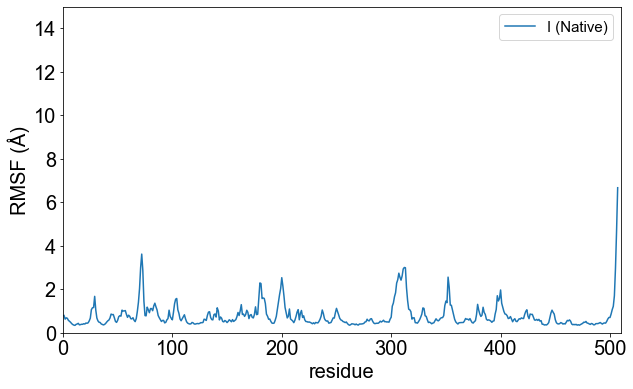

In [25]:
#Plot the data
plt.rcParams['font.size']=20

#Plot the figure
plt.figure(figsize=(10,6))

RMSF_COLOR = 'blue' #Color of the line
plt.plot(rmsf_data_I.T[0], 10*rmsf_data_I.T[1])
plt.ylim(0, 15)
plt.xlim(0, 510)
plt.xlabel('residue')
plt.ylabel('RMSF (Å)')
plt.legend([ 'I (Native)'], fontsize=15, bbox_to_anchor =(1, 1), ncol = 2)
plt.savefig('./cMD_RMSF_I.png', bbox_inches='tight')


## Glc Semi-Open

In [27]:
aver_frame_II = pt.mean_structure(trajectory_II, rmsfit=None)  # No fitting as we did it before
#Now align traj to this frame (only core protein)
traj_II_rmsf = pt.align(trajectory_II, ref=aver_frame_II, ref_mask='ref_SELECTION')
#Now get the RMSF related to averaged sturcture
rmsf_data_II = pt.rmsf(traj_II_rmsf, mask='@CA', options='byres')
rmsf_data_II

rmsf_data_II_pd = pd.DataFrame(10*rmsf_data_II)
rmsf_data_II_pd.to_csv('./csvfiles/cMD_rmsf_II.csv')


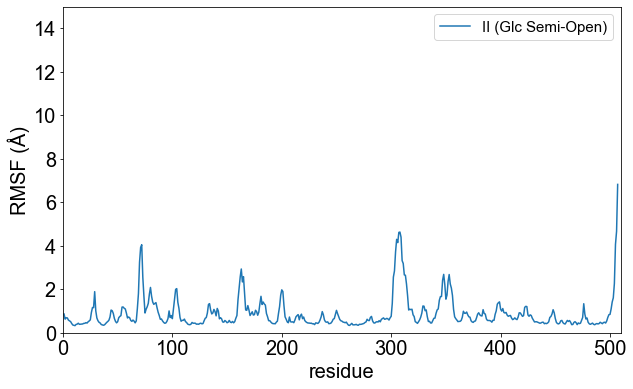

In [27]:
#Plot the data
plt.rcParams['font.size']=20

#Plot the figure
plt.figure(figsize=(10,6))

RMSF_COLOR = 'blue' #Color of the line
plt.plot(rmsf_data_II.T[0], 10*rmsf_data_II.T[1])
plt.ylim(0, 15)
plt.xlim(0, 510)
plt.xlabel('residue')
plt.ylabel('RMSF (Å)')
plt.legend([ 'II (Glc Semi-Open)'], fontsize=15, bbox_to_anchor =(1, 1), ncol = 2)
plt.savefig('./cMD_RMSF_II.png', bbox_inches='tight')


## Glc Open

In [28]:
aver_frame_III = pt.mean_structure(trajectory_III, rmsfit=None)  # No fitting as we did it before
#Now align traj to this frame (only core protein)
traj_III_rmsf = pt.align(trajectory_III, ref=aver_frame_III, ref_mask='ref_SELECTION')
#Now get the RMSF related to averaged sturcture
rmsf_data_III = pt.rmsf(traj_III_rmsf, mask='@CA', options='byres')
rmsf_data_III

rmsf_data_III_pd = pd.DataFrame(10*rmsf_data_III)
rmsf_data_III_pd.to_csv('./csvfiles/cMD_rmsf_III.csv')


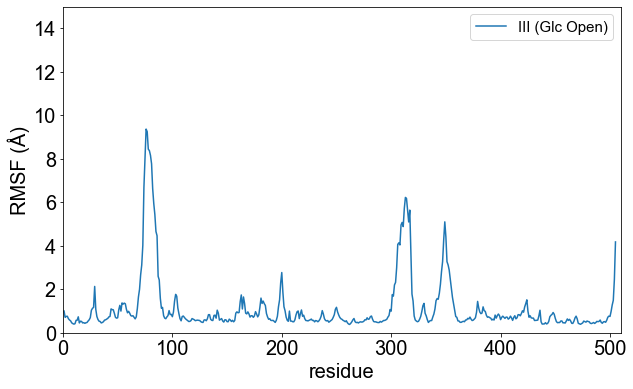

In [29]:
#Plot the data
plt.rcParams['font.size']=20

#Plot the figure
plt.figure(figsize=(10,6))

RMSF_COLOR = 'blue' #Color of the line
plt.plot(rmsf_data_III.T[0], 10*rmsf_data_III.T[1])
plt.ylim(0, 15)
plt.xlim(0, 510)
plt.xlabel('residue')
plt.ylabel('RMSF (Å)')
plt.legend([ 'III (Glc Open)'], fontsize=15, bbox_to_anchor =(1, 1), ncol = 2)
plt.savefig('./cMD_RMSF_III.png', bbox_inches='tight')


## Mang Open

In [29]:
aver_frame_IV = pt.mean_structure(trajectory_IV, rmsfit=None)  # No fitting as we did it before
#Now align traj to this frame (only core protein)
traj_IV_rmsf = pt.align(trajectory_IV, ref=aver_frame_IV, ref_mask='ref_SELECTION')
#Now get the RMSF related to averaged sturcture
rmsf_data_IV = pt.rmsf(traj_IV_rmsf, mask='@CA', options='byres')
rmsf_data_IV

rmsf_data_IV_pd = pd.DataFrame(10*rmsf_data_IV)
rmsf_data_IV_pd.to_csv('./csvfiles/cMD_rmsf_IV.csv')


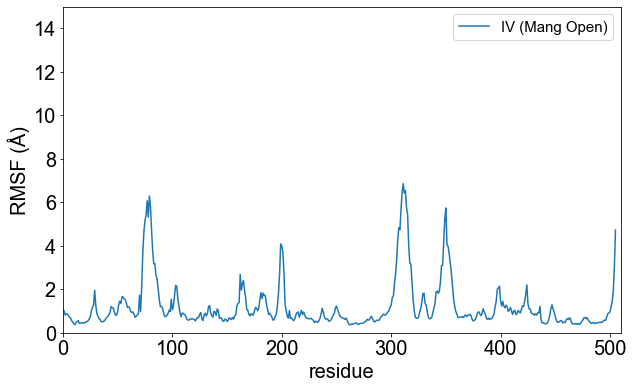

In [30]:
#Plot the data
plt.rcParams['font.size']=20

#Plot the figure
plt.figure(figsize=(10,6))

RMSF_COLOR = 'blue' #Color of the line
plt.plot(rmsf_data_IV.T[0], 10*rmsf_data_IV.T[1])
plt.ylim(0, 15)
plt.xlim(0, 510)
plt.xlabel('residue')
plt.ylabel('RMSF (Å)')
plt.legend([ 'IV (Mang Open)'], fontsize=15, bbox_to_anchor =(1, 1), ncol = 2)
plt.savefig('./cMD_RMSF_IV.png', bbox_inches='tight')


# Radius of Gyration
### pytraj.radgyr(traj=None, mask='', top=None, nomax=True, frame_indices=None, dtype='ndarray')

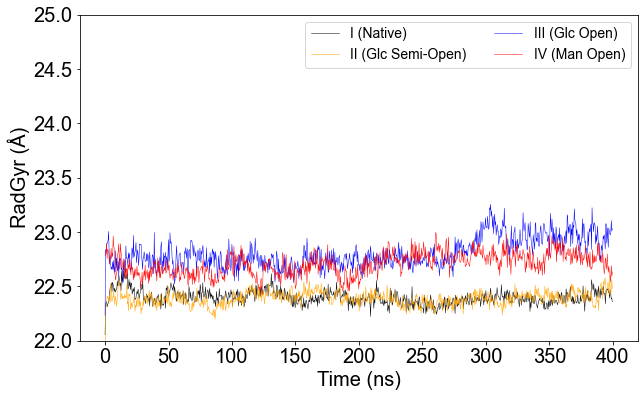

In [11]:
radgyr_I = pt.radgyr(trajectory_I, mask='ref_SELECTION')
radgyr_II = pt.radgyr(trajectory_II, mask='ref_SELECTION')
radgyr_III = pt.radgyr(trajectory_III, mask='ref_SELECTION')
radgyr_IV = pt.radgyr(trajectory_IV, mask='ref_SELECTION')


radgyr_I_pd = pd.DataFrame(10*radgyr_I)
radgyr_II_pd = pd.DataFrame(10*radgyr_II)
radgyr_III_pd = pd.DataFrame(10*radgyr_III)
radgyr_IV_pd = pd.DataFrame(10*radgyr_IV)


radgyr_I_pd.to_csv('./csvfiles/cMD_radgyr_I.csv')
radgyr_II_pd.to_csv('./csvfiles/cMD_radgyr_II.csv')
radgyr_III_pd.to_csv('./csvfiles/cMD_radgyr_III.csv')
radgyr_IV_pd.to_csv('./csvfiles/cMD_radgyr_IV.csv')

plt.rcParams['font.size']=20
plt.figure(figsize=(10,6))

plt.plot([TRAJECTORY_LENGTH*a/len(radgyr_I) for a in range(len(10*radgyr_I))], 10*radgyr_I, linewidth=0.5, color='black')
plt.plot([TRAJECTORY_LENGTH*a/len(radgyr_II) for a in range(len(10*radgyr_II))], 10*radgyr_II, linewidth=0.5, color='orange')
plt.plot([TRAJECTORY_LENGTH*a/len(radgyr_III) for a in range(len(10*radgyr_III))], 10*radgyr_III, linewidth=0.5, color='blue')
plt.plot([TRAJECTORY_LENGTH*a/len(radgyr_IV) for a in range(len(10*radgyr_IV))], 10*radgyr_IV, linewidth=0.5, color='red')

plt.ylim(22, 25)
plt.yticks(ticks=[22.0, 22.5, 23, 23.5, 24, 24.5, 25])
#plt.xlim(0, 400)
plt.xlabel('Time (ns)')
plt.ylabel('RadGyr (Å)')
plt.legend(['I (Native)', 'II (Glc Semi-Open)', 'III (Glc Open)', 'IV (Man Open)'], fontsize=14, bbox_to_anchor =(1, 1), ncol = 2)



plt.savefig('./cMD_RADGYR.png', bbox_inches='tight')
plt.show()




In [33]:
print(radgyr_I)
print(radgyr_I*10)

[2.20555406 2.23251864 2.23578593 ... 2.23847922 2.23921559 2.23585787]
[22.05554063 22.32518638 22.35785927 ... 22.3847922  22.39215591
 22.35857869]
